# Spatial analysis across multiple regions

In [21]:
# Import necessary libraries
import muspan as ms
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 

# Load immune cell data from a CSV file into a DataFrame - we'll grab the csv from our website
colon_ad_immune = pd.read_csv('https://www.docs.muspan.co.uk/workshops/data_for_workshops/Adenoma_Immune.csv')
colon_ad_immune

,Unnamed: 0,Object Id,XMin,YMin,T Helper Cell,Treg Cell,Cytotoxic T Cell,Macrophage,Neutrophil,Epithelium,...,CD68 (Opal 620) Cytoplasm Intensity,CD8 (Opal 650) Cytoplasm Intensity,ECad (Opal 690) Cytoplasm Intensity,Cell Area (µm²),Cytoplasm Area (µm²),Membrane Area (µm²),Nucleus Area (µm²),Nucleus Perimeter (µm),Nucleus Roundness,Classifier Label
0,0,0,21358,20644,0,0,0,0,0,0,...,0.128205,0.160601,1.252720,66.11719,53.73569,0,12.38150,14.43110,0.703656,epi
1,1,1,21361,20659,0,0,0,0,0,1,...,0.209170,0.193062,1.821321,133.22490,88.89915,0,44.32576,30.85271,0.636474,epi
2,2,2,21377,20678,0,0,0,0,0,1,...,0.288331,0.288142,2.769074,85.67995,74.04135,0,11.63861,13.93348,0.838873,epi
3,3,3,21383,20709,0,0,0,0,0,0,...,0.141584,0.190175,1.341652,154.76870,89.14677,0,65.62193,38.31707,0.646902,epi
4,4,4,21355,20711,0,0,0,0,0,1,...,0.526328,0.317425,2.210780,245.15360,139.66330,0,105.49030,52.25055,0.624307,epi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274677,274677,274677,13855,32236,0,1,0,1,0,1,...,2.503274,0.615916,1.547021,74.78424,55.96436,0,18.81987,17.91447,0.787028,stroma
274678,274678,274678,13789,32238,1,0,0,0,0,0,...,0.130234,0.250628,0.965695,77.50816,62.15511,0,15.35306,16.91923,0.645897,stroma
274679,274679,274679,14050,32239,0,0,0,0,0,0,...,0.126561,0.199811,0.704792,57.45014,44.82102,0,12.62913,15.92398,0.549334,stroma
274680,274680,274680,14065,32242,1,0,0,0,0,0,...,0.146052,0.214028,0.862087,100.04250,82.46076,0,17.58172,16.42160,0.813634,stroma


['Unnamed: 0', 'Object Id', 'XMin', 'YMin', 'T Helper Cell', 'Treg Cell', 'Cytotoxic T Cell', 'Macrophage', 'Neutrophil', 'Epithelium', 'CD4 (Opal 520) Cytoplasm Intensity', 'MPO (Opal 540) Cytoplasm Intensity', 'FoxP3 (Opal 570) Cytoplasm Intensity', 'CD68 (Opal 620) Cytoplasm Intensity', 'CD8 (Opal 650) Cytoplasm Intensity', 'ECad (Opal 690) Cytoplasm Intensity', 'Cell Area (µm²)', 'Cytoplasm Area (µm²)', 'Membrane Area (µm²)', 'Nucleus Area (µm²)', 'Nucleus Perimeter (µm)', 'Nucleus Roundness', 'Classifier Label']


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

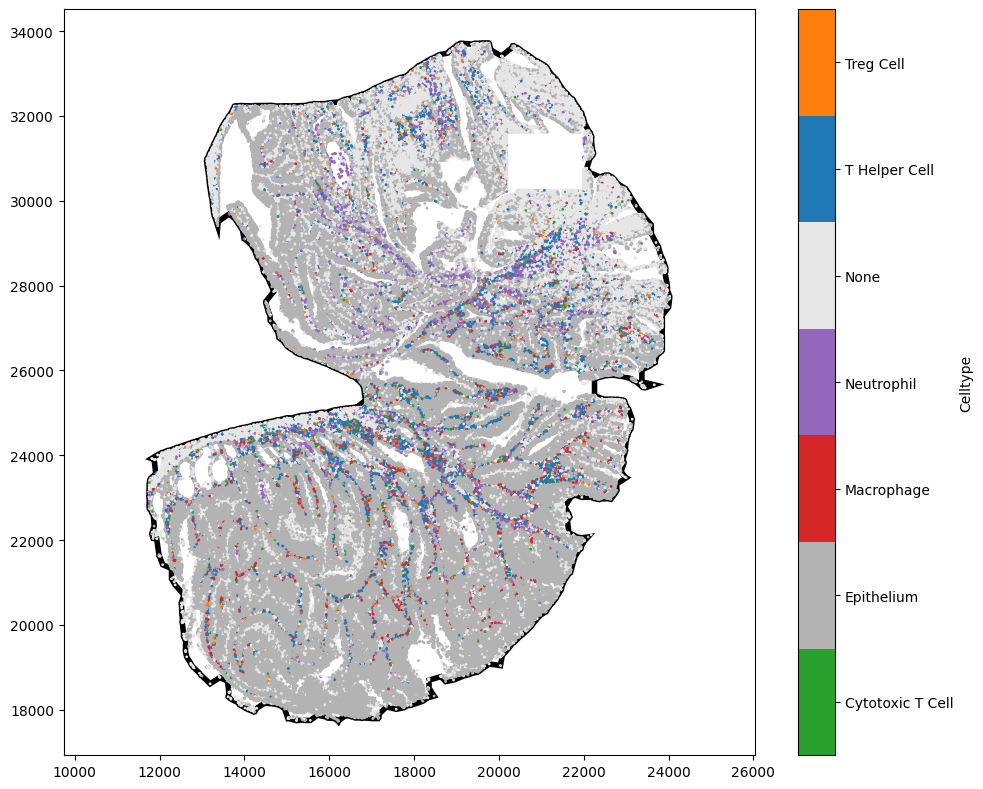

In [18]:
# Get the list of columns in the DataFrame
cols = colon_ad_immune.columns.tolist()

# Create a new DataFrame with the same columns
colon_ad_immune_out = colon_ad_immune[cols]

# Extract coordinates for the points (XMin, YMin) and create a mask for cell types
pts = np.array([colon_ad_immune['XMin'], colon_ad_immune['YMin']]).T
mask = np.zeros(len(pts))

# Dictionary to map cell type indices to their names
ctdict = {
    0: 'None',
    1: 'T Helper Cell',
    2: 'Treg Cell', 
    3: 'Cytotoxic T Cell', 
    4: 'Macrophage',
    5: 'Neutrophil', 
    6: 'Epithelium'
}

# Assign indices to the mask based on the presence of each cell type
for i, ct in enumerate(['T Helper Cell', 'Treg Cell', 'Cytotoxic T Cell', 'Macrophage', 'Neutrophil', 'Epithelium']):
    mask[colon_ad_immune[ct] == 1] = i + 1

# Create labels for each point based on the mask
labels = [ctdict[v] for v in mask]

# Create a muspan domain object
domain = ms.domain('adcar')

# Add points and labels to the domain
domain.add_points(pts, collection_name='Immune cells')
domain.add_labels('Celltype', labels)

# Define colors for each cell type
newcolors = {
    'None': [0.9, 0.9, 0.9, 1],
    'T Helper Cell': plt.cm.tab10(0),
    'Treg Cell': plt.cm.tab10(1), 
    'Cytotoxic T Cell': plt.cm.tab10(2), 
    'Macrophage': plt.cm.tab10(3),
    'Neutrophil': plt.cm.tab10(4), 
    'Epithelium': [0.7, 0.7, 0.7, 1]
}

# Update the domain colors based on the defined color mapping
domain.update_colors(newcolors, label_name='Celltype')

# Estimate the boundary of the domain using the alpha shape method
domain.estimate_boundary(method='alpha shape', alpha_shape_kwargs=dict(alpha=200))    

# Visualize the domain with the cell type labels and boundary
ms.visualise.visualise(domain, 'Celltype', marker_size=1, show_boundary=True)

This is a massive sample, let's generate some lattice to break the domain down into some smaller regions. We'll first do this by generating some hexaginal lattice

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

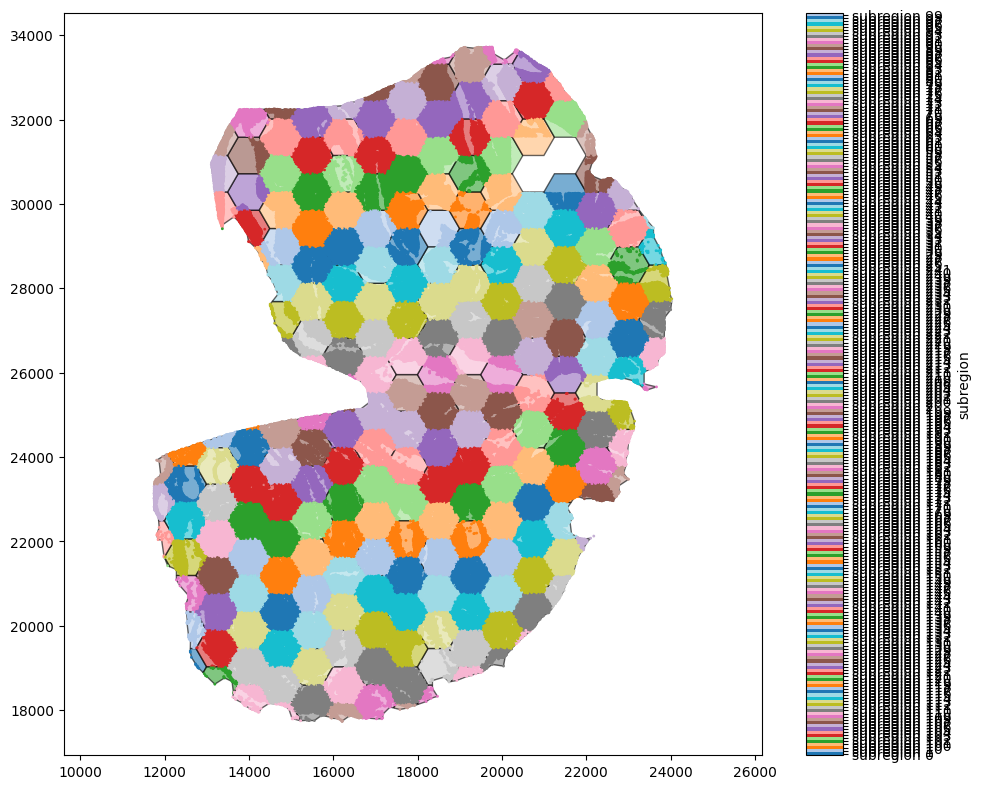

In [2]:
ms.region_based.generate_hexgrid(domain,side_length=500,region_label_name='subregion',regions_collection_name='subregions')
ms.visualise.visualise(domain, 'subregion', marker_size=1)  

So we now have labels for each object assigning them to a subregion in space. We can now do two things:
1. Using the generated lattice shapes as boundaries for statistics to compute stats within each region;
2. Generate new domains for each subregion using the `ms.helpers.crop_domains` function in muspan;


We'll go with 1 for now so we can visualise the spatial heterogenity of our spatial analysis. If we want to compute statistics within each region, we'll need to know what region label categories we have. We can grab these using the `ms.query.get_labels()` function: 

In [3]:
# Retrieve labels for subregions from the domain
subregions_labels, _ = ms.query.get_labels(domain, 'subregion')

# Get unique categories of subregions
subregions_labels_categories = np.unique(subregions_labels)

# Print the unique subregion categories
print(subregions_labels_categories)


['subregion 0' 'subregion 1' 'subregion 10' 'subregion 100'
 'subregion 101' 'subregion 102' 'subregion 103' 'subregion 104'
 'subregion 105' 'subregion 106' 'subregion 107' 'subregion 108'
 'subregion 109' 'subregion 11' 'subregion 110' 'subregion 111'
 'subregion 112' 'subregion 113' 'subregion 114' 'subregion 115'
 'subregion 116' 'subregion 117' 'subregion 118' 'subregion 119'
 'subregion 12' 'subregion 120' 'subregion 121' 'subregion 122'
 'subregion 123' 'subregion 124' 'subregion 125' 'subregion 126'
 'subregion 127' 'subregion 128' 'subregion 129' 'subregion 13'
 'subregion 130' 'subregion 131' 'subregion 132' 'subregion 133'
 'subregion 134' 'subregion 135' 'subregion 136' 'subregion 137'
 'subregion 138' 'subregion 139' 'subregion 14' 'subregion 140'
 'subregion 141' 'subregion 142' 'subregion 143' 'subregion 144'
 'subregion 145' 'subregion 146' 'subregion 147' 'subregion 148'
 'subregion 149' 'subregion 15' 'subregion 150' 'subregion 151'
 'subregion 152' 'subregion 153' 's

For now, we'll keep it simple and just compute the density of cells in each region of our sample. We'll add the resultant densities as labels to the region shapes and also store the raw numeric outputs in a list.

In [4]:
# make some empty lists to hold results
Neutrophil_density = []    

for subregion_id in subregions_labels_categories:
    
    # get the boundary shape of the subregion
    this_shape_boundary = ms.query.query_container(('collection','subregions'),'AND',('subregion',subregion_id),domain)
    
    # get the cell population within the subregion
    this_sub_population = ms.query.query_container(('collection','Immune cells'),'AND',('subregion',subregion_id),domain)
    
    # run a statistic (here we'll be really bold and just calculate cell density)
    cell_density,_,label_categories = ms.summary_statistics.label_density(domain,label_name='Celltype',population=this_sub_population,include_boundaries=this_shape_boundary)
    
    # add result to a list (just Neutrophils for now)
    this_Neutrophil_density = 0
    if 'Neutrophil' in label_categories:
        neutrophil_index = np.where(label_categories=='Neutrophil')[0][0]
        this_Neutrophil_density = cell_density[neutrophil_index]

    Neutrophil_density.append(this_Neutrophil_density)
    
    # add result to the region shapa as a label (just Neutrophils for now)
    domain.add_labels('neutrophil density', [this_Neutrophil_density], add_labels_to=this_shape_boundary,label_type='continuous')


Now we've computed our neutrophil densities, let's visualise this on our tissue

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

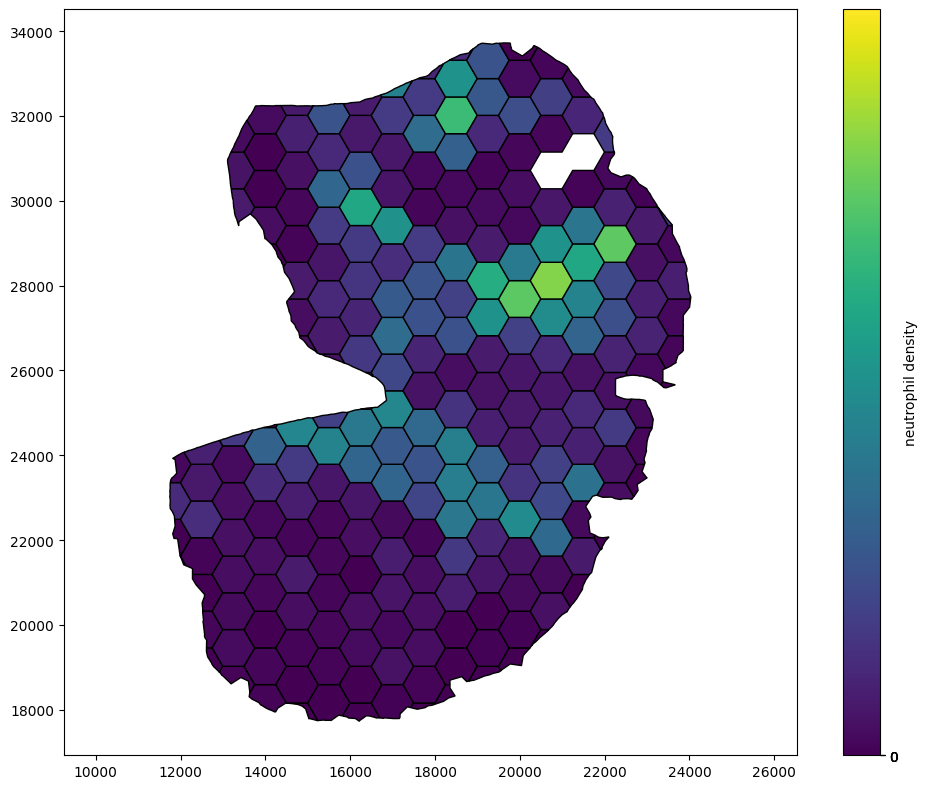

In [10]:
ms.visualise.visualise(domain,'neutrophil density', objects_to_plot=('collection','subregions'),vmin=0,vmax=5e-4, shape_kwargs=dict(alpha=1))

We can also plot our numeric densities as a histogram

Text(0, 0.5, 'Frequency')

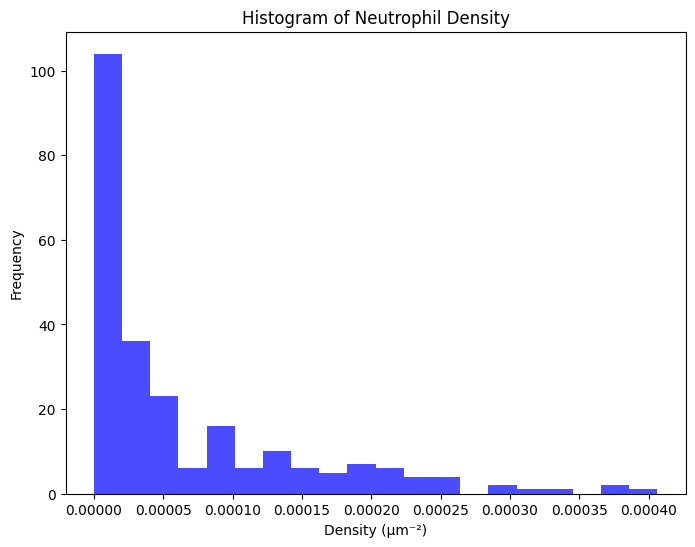

In [16]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.hist(Neutrophil_density, bins=20, color='blue', alpha=0.7)
ax.set_title('Histogram of Neutrophil Density')
ax.set_xlabel('Density (µm⁻²)')
ax.set_ylabel('Frequency')


### Spatial analysis in multiple regions

Now that we understand how to compute a spatial metric within subregions of the tissue, we can move on to more informative metrics that describe spatial correlations between cell types:
1. Run the QCM to identify pairs of cell types that are co-localised or mutually excluded (make sure to note the chosen region size).
2. Divide the tissue domain into regions of that same size.
3. For each region, compute the cross-PCF for the cell-type pairs of interest and extract a summary statistic (e.g. a scalar value such as g(r = 0)).
4. Attach these summary values to the corresponding region shapes for visualisation.
5. Finally, apply the Getis-Ord statistic to the region shapes to identify hotspots—areas where regions with similar summary statistics cluster together.
